<a href="https://colab.research.google.com/github/ianakoto/Cropland-Mapping/blob/main/Dataset_Creation_GEO_AI_Challenge_for_Cropland_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEO-AI Challenge for Cropland Mapping- Dataset Creation



This project is broken into the following notebooks:

- **Open 🧭 Overview**: Go through what we want to achieve, and explore the data we want to use as inputs and outputs for our model.

- **Open 🗄️ Create the dataset**: Use Apache Beam to fetch data from Earth Engine in parallel, and create a dataset for our model in Dataflow.

- **Open 🧠 Train the model**: Build a Unet with pretained model and train it in Vertex AI with the dataset we created.

- **Open 🔮 Model predictions**: Get predictions from the model with data it has never seen before.

This sample leverages geospatial satellite data from Google Earth Engine. Using satellite imagery, you'll build and train a model for Cropland classification

## Image Preprocessing:

**Preprocess Sentinel-2 imagery to make it suitable for model training.**

This may include:

- cloud masking
- shadow removal
- and data normalization.

**You can adapt the preprocessing steps described in the methodology to your dataset.**

# 🎬 Before you begin

Let's start by cloning the GitHub repository, and installing some dependencies.

In [ ]:
!rm -r /content/Cropland-Mapping

In [ ]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/ianakoto/Cropland-Mapping.git
%cd Cropland-Mapping/serving

Cloning into 'Cropland-Mapping'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 394 (delta 120), reused 207 (delta 85), pack-reused 146
Receiving objects: 100% (394/394), 904.20 KiB | 9.13 MiB/s, done.
Resolving deltas: 100% (206/206), done.
/content/Cropland-Mapping/serving


In [ ]:
!pip install -q earthengine-api

!pip install -q openpyxl

# Upgrade `setuptools` to install packages from pyproject.toml files.
!pip install --quiet --upgrade --no-warn-conflicts pip setuptools

# We need `build` and `virtualenv` to build the local packages.
!pip install --quiet build virtualenv

# Install Apache Beam
!pip install --quiet apache-beam[gcp]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Alternatively, restart the runtime by ending the process.
exit()

After restarting the runtime, let's navigate back into the package directory.

In [ ]:
%cd /content/Cropland-Mapping/serving

/content/Cropland-Mapping/serving


Build the package

In [ ]:
#  the backage is already built
#!python setup.py sdist bdist_wheel

Install the package

In [ ]:
# Install the custom package
!pip install -q dist/croplandclassification-0.0.1.tar.gz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## ☁️ My Google Cloud resources

Make sure you have followed these steps to configure your Google Cloud project:

1. Enable the APIs: _Earth Engine_

  <button>

  [Click here to enable the APIs](https://console.cloud.google.com/flows/enableapi?apiid=earthengine.googleapis.com)
  </button>

1. Register your
  [Compute Engine default service account](https://console.cloud.google.com/iam-admin/iam)
  on Earth Engine.

  <button>

  [Click here to register your service account on Earth Engine](https://signup.earthengine.google.com/#!/service_accounts)
  </button>

Once you have everything ready, you can go ahead and fill in your Google Cloud resources in the following code cell.
Make sure you run it!

### ✏️ Enter your Cloud project's details. Ensure you provide a regional bucket!

In [ ]:
from __future__ import annotations

import os
from google.colab import auth

# Please fill in these values.
project = "kagglex-396821"  # @param {type:"string"}
bucket = "cropland_classification_data"  # @param {type:"string"}
location = "us (multiple regions in United States)"  # @param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith(
    "gs://"
), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ["GOOGLE_CLOUD_PROJECT"] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


## Import Earth Engine API and authenticate<a class="anchor" id="import-api"></a>

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [ ]:
import ee
from datetime import datetime, timedelta
import io
import pandas as pd
import random
import numpy as np
from google.cloud import storage
import apache_beam as beam
from sklearn.model_selection import train_test_split

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
## Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Jf2QNuzpPGNr6IxkqII1YkcRVtTzAVAHP3p9a1LK0V0&tc=J4vVWffozjrdbRGztzQP9PqvzJx84yFpptW-fg4ceN4&cc=wBDzwZG5FEpvhFIwqU7Lb1BGBc_2VrDBdcntUr58UOM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXnj1sUN4jPRfmyCqHKpfKocHc53UmIyhZlg0sUhO7tSxlZbVE6DYro

Successfully saved authorization token.


**Make Sure to Authenticate to Earth Engine Before running the below**

In [ ]:
import os
import sys

from croplandclassification.data import *
from croplandclassification.utils import *

## Load Dataset From Drive

In [ ]:
train_pd = pd.read_csv("/content/drive/MyDrive/Zindi Competitions/Cropland Classification/Train.csv")
sample_pd = pd.read_csv("/content/drive/MyDrive/Zindi Competitions/Cropland Classification/SampleSubmission.csv")
test_pd = pd.read_csv("/content/drive/MyDrive/Zindi Competitions/Cropland Classification/Test.csv")

In [ ]:
train_pd.head()

,ID,Lat,Lon,Target
0,ID_SJ098E7S2SY9,34.162491,70.763668,0
1,ID_CWCD60FGJJYY,32.075695,48.492047,0
2,ID_R1XF70RMVGL3,14.542826,33.313483,1
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1
4,ID_C20R2C0AYIT0,14.419128,33.528450,0


In [ ]:
sample_pd.head()

,ID,Target
0,ID_9ZLHTVF6NSU7,
1,ID_LNN7BFCVEZKA,
2,ID_SOYSG7W04UH3,
3,ID_EAP7EXXV8ZDE,
4,ID_QPRX1TUQVGHU,


In [ ]:
test_pd.head()

,ID,Lat,Lon
0,ID_9ZLHTVF6NSU7,34.254835,70.348699
1,ID_LNN7BFCVEZKA,32.009669,48.535526
2,ID_SOYSG7W04UH3,14.431884,33.399991
3,ID_EAP7EXXV8ZDE,14.281866,33.441224
4,ID_QPRX1TUQVGHU,14.399365,33.109566


In [ ]:
test_pd.shape

(1500, 3)

## 🔄 More Data In the Data Pipeline 📊

The above is data is small

- We need 1000 samples for each region for training the model. Hence we will sample points in the various regions on a **cropland dataset** and build a training dataset. Then we add those records to the already given record.

- Next, we will want to build a pipeline to move data from **Earth Engine** to **GCP as TFrecord**.


**To generate more data, 1000 samples for each region except afghan, which we derived 500, which we are gong to use** [MCD12Q1.061 MODIS Land Cover Type Yearly Global 500m](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1) and [Google Dynamic World V1](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1).

**MODIS LANDCOVER FOR 2019 to 2022**

The Terra and Aqua combined Moderate Resolution Imaging Spectroradiometer (MODIS) Land Cover Type (MCD12Q1) Version 6.1 data product provides global land cover types at yearly intervals. The MCD12Q1 Version 6.1 data product is derived using supervised classifications of MODIS Terra and Aqua reflectance data. Land cover types are derived from the International Geosphere-Biosphere Programme (IGBP), University of Maryland (UMD), Leaf Area Index (LAI), BIOME-Biogeochemical Cycles (BGC), and Plant Functional Types (PFT) classification schemes. The supervised classifications then underwent additional post-processing that incorporate prior knowledge and ancillary information to further refine specific classes. Additional land cover property assessment layers are provided by the Food and Agriculture Organization (FAO) Land Cover Classification System (LCCS) for land cover, land use, and surface hydrology.

Layers for Land Cover Type 1-5, Land Cover Property 1-3, Land Cover Property Assessment 1-3, Land Cover Quality Control (QC), and a Land Water Mask are also provided.


**GOOGLE DYNAMIC WORLD**

Dynamic World is a 10m near-real-time (NRT) Land Use/Land Cover (LULC) dataset that includes class probabilities and label information for nine classes.

Dynamic World predictions are available for the Sentinel-2 L1C collection from 2015-06-27 to present. The revisit frequency of Sentinel-2 is between 2-5 days depending on latitude. Dynamic World predictions are generated for Sentinel-2 L1C images with CLOUDY_PIXEL_PERCENTAGE <= 35%. Predictions are masked to remove clouds and cloud shadows using a combination of S2 Cloud Probability, Cloud Displacement Index, and Directional Distance Transform.

Images in the Dynamic World collection have names matching the individual Sentinel-2 L1C asset names from which they were derived, e.g:

ee.Image('COPERNICUS/S2/20160711T084022_20160711T084751_T35PKT')

has a matching Dynamic World image named: ee.Image('GOOGLE/DYNAMICWORLD/V1/20160711T084022_20160711T084751_T35PKT').

All probability bands except the "label" band collectively sum to 1.

## 📌 Sample points

First, we want to get balanced points for a given time.
We use [`ee.Image.stratifiedSample`](https://developers.google.com/earth-engine/apidocs/ee-image-stratifiedsample) to select around the same number of points for each amount of cropland labels.

So it's important to make sure we select data points from different elevations in a balanced way.

In [ ]:
sampled_iran, sampled_sudan, sampled_afghanistan = sample_cropland_points()


In [ ]:
# Print the sampled data information
print(sampled_afghanistan.getInfo())


{'type': 'FeatureCollection', 'columns': {}, 'properties': {'band_order': ['Cropland']}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [70.37626514613362, 34.178650772537495]}, 'id': '0', 'properties': {'Cropland': 0, 'ID': 'ID_018a9b40686d', 'Latitude': 34.178650772537495, 'Longitude': 70.37626514613362}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [70.7715238711462, 34.18314234895809]}, 'id': '1', 'properties': {'Cropland': 0, 'ID': 'ID_018a9b40686d', 'Latitude': 34.18314234895809, 'Longitude': 70.7715238711462}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [70.69965864841664, 34.569417921129485]}, 'id': '2', 'properties': {'Cropland': 0, 'ID': 'ID_018a9b40686d', 'Latitude': 34.569417921129485, 'Longitude': 70.69965864841664}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [70.3897398753954, 34.07085293844315]}, 'id'

In [ ]:
# Define the export configuration
output_folder='Zindi Competitions/Cropland Classification/'
export_filename='cropland_samples'
export_config = {
    'collection_iran': sampled_iran,
    'collection_sudan': sampled_sudan,
    'collection_afghanistan': sampled_afghanistan,
    'description_iran': export_filename + '_iran_1000',
    'description_sudan': export_filename + '_sudan_1000',
    'description_afghanistan': export_filename + '_afghanistan_500',
    'folder': output_folder,
    'fileFormat': 'CSV',
    'selectors':['ID', 'Latitude', 'Longitude', 'Cropland']  # Specify the columns to include in the export
}

In [ ]:
# Export the sampled points to Google Drive
task_iran = ee.batch.Export.table.toDrive(
    collection=export_config['collection_iran'],
    description=export_config['description_iran'],
    folder = export_config['folder'],
    fileFormat=export_config['fileFormat'],
    selectors=export_config['selectors'])

task_sudan = ee.batch.Export.table.toDrive(
    collection=export_config['collection_sudan'],
    description=export_config['description_sudan'],
    folder = export_config['folder'],
    fileFormat=export_config['fileFormat'],
    selectors=export_config['selectors'])

task_afghanistan =ee.batch.Export.table.toDrive(
    collection=export_config['collection_afghanistan'],
    description=export_config['description_afghanistan'],
    folder = export_config['folder'],
    fileFormat=export_config['fileFormat'],
     selectors=export_config['selectors'])

In [ ]:
tasks = [task_iran, task_sudan, task_afghanistan]

In [ ]:
# Start the export tasks
monitor_ee_tasks(tasks)

Monitoring tasks...

Task 1 completed successfully!

File Description: cropland_samples_iran_1000

Destination url: ['https://drive.google.com/#folders/1BwH7hFiXcloubLCD5tTVOGoDXz_QMsnx']


Task 2 completed successfully!

File Description: cropland_samples_sudan_1000

Destination url: ['https://drive.google.com/#folders/1vUfnc1GdnUFRgGGLIB-27fBoBxTF34jd']


Task 3 completed successfully!

File Description: cropland_samples_afghanistan_500

Destination url: ['https://drive.google.com/#folders/1yIds38VWK6ouhTuWGe37skZzQKXhV2-O']



- Now that we have got some additional training data we would want to combine all and add to the given training samples.

- Then we will divide the data into train, valid and test splits

- Next, we will export the labelled patches into gcp bucket in tfrecord format for training our models

## 📊 Combining newly acquired training data with existing samples 📈



Make sure to get the google drive path and use it to get the generated training samples below

In [ ]:
sudan_sample_pd = pd.read_csv("/content/drive/MyDrive/Zindi Competitions Cropland Classification  (1)/cropland_samples_sudan_1000.csv")
iran_sample_pd = pd.read_csv("/content/drive/MyDrive/Zindi Competitions Cropland Classification  (2)/cropland_samples_iran_1000.csv")
afghan_sample_pd = pd.read_csv("/content/drive/MyDrive/Zindi Competitions Cropland Classification /cropland_samples_afghanistan_500.csv")


In [ ]:
sudan_sample_pd.head()

,ID,Latitude,Longitude,Cropland
0,ID_018a9a61ead7,21.638169,33.868732,0
1,ID_018a9a61ead7,11.064999,31.286076,0
2,ID_018a9a61ead7,19.347465,33.343218,0
3,ID_018a9a61ead7,19.455263,31.232177,0
4,ID_018a9a61ead7,18.071858,37.637165,0


In [ ]:
iran_sample_pd.head()

,ID,Latitude,Longitude,Cropland
0,ID_018a9a61ead5,33.051265,56.488311,0
1,ID_018a9a61ead5,26.700176,62.012950,0
2,ID_018a9a61ead5,34.789505,57.368660,0
3,ID_018a9a61ead5,26.560937,57.543831,0
4,ID_018a9a61ead5,38.257002,47.006593,0


In [ ]:
afghan_sample_pd.head()

,ID,Latitude,Longitude,Cropland
0,ID_018a9a61eadd,34.178651,70.376265,0
1,ID_018a9a61eadd,34.183142,70.771524,0
2,ID_018a9a61eadd,34.569418,70.699659,0
3,ID_018a9a61eadd,34.070853,70.389740,0
4,ID_018a9a61eadd,34.003479,70.484063,0


In [ ]:
# Concatenate the DataFrames vertically
total_sample_df = pd.concat([sudan_sample_pd,
                         iran_sample_pd,
                         afghan_sample_pd],
                        ignore_index=True)

In [ ]:
total_sample_df.rename(columns={'Cropland': 'Target',
                                'Latitude': 'Lat',
                                'Longitude': 'Lon'},
                       inplace=True)


In [ ]:
total_sample_df.head()

,ID,Lat,Lon,Target
0,ID_018a9a61ead7,21.638169,33.868732,0
1,ID_018a9a61ead7,11.064999,31.286076,0
2,ID_018a9a61ead7,19.347465,33.343218,0
3,ID_018a9a61ead7,19.455263,31.232177,0
4,ID_018a9a61ead7,18.071858,37.637165,0


In [ ]:
total_sample_df.shape

(4500, 4)

In [ ]:
train_pd.head()

,ID,Lat,Lon,Target
0,ID_SJ098E7S2SY9,34.162491,70.763668,0
1,ID_CWCD60FGJJYY,32.075695,48.492047,0
2,ID_R1XF70RMVGL3,14.542826,33.313483,1
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1
4,ID_C20R2C0AYIT0,14.419128,33.528450,0


In [ ]:
total_train_df = pd.concat([train_pd, total_sample_df], ignore_index=True)

In [ ]:
total_train_df.head()

,ID,Lat,Lon,Target
0,ID_SJ098E7S2SY9,34.162491,70.763668,0
1,ID_CWCD60FGJJYY,32.075695,48.492047,0
2,ID_R1XF70RMVGL3,14.542826,33.313483,1
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1
4,ID_C20R2C0AYIT0,14.419128,33.528450,0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def check_class_balance(df, label_column_name, threshold=0.1):
    # Count the number of labels for each class
    class_counts = df[label_column_name].value_counts()

    # Calculate the proportion of each class
    class_proportions = class_counts / len(df)

    # Check if the classes are unbalanced
    is_unbalanced = any(class_proportions < threshold)

    # Print the class counts and proportions
    print("Class Counts:")
    print(class_counts)
    print("\nClass Proportions:")
    print(class_proportions)

    # Visualize the class distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Check if it's unbalanced
    if is_unbalanced:
        print("\nThe dataset is unbalanced.")
    else:
        print("\nThe dataset is balanced.")


Class Counts:
0    3250
1    2750
Name: Target, dtype: int64

Class Proportions:
0    0.541667
1    0.458333
Name: Target, dtype: float64


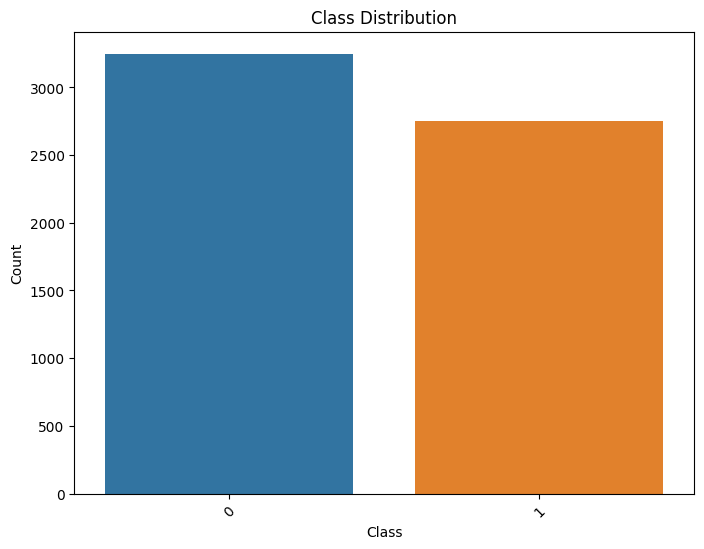


The dataset is balanced.


In [ ]:
check_class_balance(total_train_df, 'Target')

## 🖼️ Output Patches for Training Samples

To get a better sense of what's going on, let's look at the properties for the first Feature in the train_features list. You can see that it contains a property for the label is_powered_on, and 13 additional properies, one for each spectral band.



In [ ]:
first_20_rows = total_train_df.head(5)

In [ ]:
training_features =  [labeled_feature(row.Lon, row.Lat, row.Target) for row in first_20_rows.itertuples()]

In [ ]:
ee.FeatureCollection(training_features[0]).propertyNames().getInfo()

['system:index', 'is_cropland', 'B2', 'B3', 'B4', 'B8', 'EVI', 'NDWI', 'NDVI']

The data contained in each band property is an array of shape 11x11.

For example, here is the data for band B1 in the first element in our list expressed as a numpy array.

In [ ]:
example_feature = np.array(training_features[0].get("B3").getInfo())
print(example_feature)
print("shape: " + str(example_feature.shape))

[[0.1596     0.168      0.1701     0.17030001 0.16680001 0.17245001
  0.17245001 0.16410001 0.16060001 0.17290001 0.1814    ]
 [0.1683     0.17309999 0.1734     0.16235    0.16150001 0.16150001
  0.1752     0.17105    0.16355    0.1717     0.18099999]
 [0.1682     0.16760001 0.17739999 0.16509999 0.1582     0.1582
  0.17215    0.17399999 0.17115    0.17640001 0.18099999]
 [0.1637     0.15635    0.1621     0.1696     0.1681     0.1681
  0.16755    0.1797     0.16925    0.17219999 0.17775001]
 [0.16500001 0.1636     0.15719999 0.15970001 0.17200001 0.17200001
  0.17380001 0.17460001 0.16769999 0.1647     0.1693    ]
 [0.1618     0.1657     0.1622     0.1559     0.164      0.164
  0.1804     0.17485    0.17295    0.1661     0.1531    ]
 [0.1619     0.1639     0.1696     0.1636     0.16580001 0.16580001
  0.1749     0.18709999 0.1812     0.1644     0.14120001]
 [0.1733     0.1693     0.17595001 0.175      0.17039999 0.17039999
  0.17095    0.1743     0.1859     0.1646     0.1382    ]
 [0.1

In [ ]:
example_feature.item()

0

##📦 Uploading Training Data to GCP Bucket

In [ ]:
# Create a GCS client
client = storage.Client()
destination_blob_name = 'croplandclassification/training.csv'

In [ ]:
# Save training to local for upload. Note that because we set the directory to our install package from github
# it will be saved there
total_train_df.to_csv('training.csv', index=False)

In [ ]:
# Upload the local CSV file to GCS
bucket = client.bucket(bucket)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename('/content/Cropland-Mapping/serving/training.csv')


## Extract Feature Data as TFrecord to GCP


Load csv file from GCP

In [ ]:
from io import StringIO
def load_gcs_csv_to_dataframe(bucket_name, file_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Load the CSV file into a blob
    blob = bucket.blob(file_path)
    content = blob.download_as_text()

    # Read the CSV content into a DataFrame
    df = pd.read_csv(StringIO(content))
    return df

In [ ]:
# Load the CSV file into a DataFrame
df = load_gcs_csv_to_dataframe(bucket, "croplandclassification/training.csv")

In [ ]:
df.shape

(6000, 4)